In [47]:
%matplotlib notebook
# the jupyter specific part

import ipywidgets as widget

# enlargen jupyter notebook window
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 95%; }
    div#maintoolbar-container { width: 95%; }
</style>
"""))

In [2]:
# the functional part
import numpy as np
from matplotlib import pyplot as plt
import scipy.constants as const
import typhon as tp
import matplotlib.pyplot as plt
import xarray as xr
from time import time as zeit
import math
from cartopy import crs as ccrs

from cdo import Cdo
cdo = Cdo()

if __name__ == "__main__":
    print("module: touch_dyamond")

module: touch_dyamond


# Data access and slicing

This notebook is intended to explore different ways to access climate model data from within python. This uses a script by Marius Winkler as a base. Its original intend was to plot mean wind fields. Data access times however were rather slow, in the range of one to two minutes. For opening netcdf files and separating the interesting sections, we first look at the original approach on loading the data into **xarrays** and them using xarrays utilities to slice and calculate means. We then compare to a **cdo** based approach. And finally look at the effect, that the **order of operations** has on computing times.

Computing times here have to be taken with a grain of salt, as they are the computing times of a single run on my personal laptop (Macbook pro, M1 processor). Especially cdo's ability to run in parallel make it a tool of choice for larger operations.

The most computational heavy part of this is - unsuprisingly - the last operation, that combines a time mean over the entire available dataset (343 time steps), selects a height level and a latiude-longitude box. The computation times of the separate steps are shown here:

In [ ]:
# file names

# the data is preprocessed DYAMOND output
# on mistral it is found here:
fname_ua = '/pf/m/m300845/_work_pc/data/icon/dpp0029/atm/3d/dpp0029_ml_ua_2020_1x1.nc'
fname_va = '/pf/m/m300845/_work_pc/data/icon/dpp0029/atm/3d/dpp0029_ml_va_2020_1x1.nc'

# i use a local copy of the data.
fname_ua = "/Users/admin/Desktop/jupyter/dpp0029_ml_ua_2020_1x1.nc"
fname_va = "/Users/admin/Desktop/jupyter/dpp0029_ml_va_2020_1x1.nc"

In [9]:
# operations
time = ".isel({'time': slice(1,343)}).mean(dim='time')"
plev = ".isel(height=89)"                                           
lon  = ".sel({'lon': slice(120,260)})"
lat  = ".sel({'lat': slice(-26,26)})"

# open
begin = zeit()
ds_ua    = xr.open_dataset(fname_ua)
ds_va    = xr.open_dataset(fname_va)
end = zeit()
print("Total time taken, opening netcdf files: ", end - begin)

# getting latitudes and longitude in separate arrays
begin = zeit()
x_va    = eval('ds_va.lon' + f"{lon}")
y_va    = eval('ds_va.lat' + f"{lat}")
x_ua    = eval('ds_ua.lon' + f"{lon}")
y_ua    = eval('ds_ua.lat' + f"{lat}")
end = zeit()
print("Total time taken, getting lat and lon arrays: ", end - begin)

# time averaging and slicing the wind fields
begin = zeit()
z_va    = eval('ds_va.va'  + f"{time}{plev}{lon}{lat}")
z_ua    = eval('ds_ua.ua'  + f"{time}{plev}{lon}{lat}")
end = zeit()
print("Total time taken, getting the wind data: ", end - begin)

method="xarray" # method identifier for later use (see below)

Total time taken, opening netcdf files:  0.031770944595336914
Total time taken, getting lat and lon arrays:  0.00421905517578125
Total time taken, getting the wind data:  62.231115102767944


The same operation, in its original form, everything together:

In [10]:
# joint time measurement
# xarray based, mean first
begin = zeit()

ds_ua    = xr.open_dataset(fname_ua)
ds_va    = xr.open_dataset(fname_va)

time = ".isel({'time': slice(1,343)}).mean(dim='time')"
plev = ".isel(height=89)"                                           
lon  = ".sel({'lon': slice(120,260)})"
lat  = ".sel({'lat': slice(-26,26)})"

x_ua    = eval('ds_ua.lon' + f"{lon}")
y_ua    = eval('ds_ua.lat' + f"{lat}")
z_ua    = eval('ds_ua.ua'  + f"{time}{plev}{lon}{lat}")
x_va    = eval('ds_va.lon' + f"{lon}")
y_va    = eval('ds_va.lat' + f"{lat}")
z_va    = eval('ds_va.va'  + f"{time}{plev}{lon}{lat}")

end = zeit()
print("Total time taken: ", end - begin)

method="xarray" # method identifier for later use (see below)

Total time taken:  62.912041902542114


**cdo** achieves a 7 times speed up (14% cost) with the same operations. The syntax however is slightly more complicated, as one of the operations is invoked as a public method of the `Cdo()` object, while the other are invoked with cdo's bash syntax in the `input` argument of that method. The order these operations are executed is reversed to the order they are fed into the input argument, with the last one being the one that is invoked in python syntax.

In [25]:
# joint time measurement
# cdo based, mean first
begin = zeit()

height   = '-select,level=90 '
timemean = '-timselmean,343 '
lonlat   = '-sellonlatbox,120,260,-26,26 ' 

dat1 = cdo.sellonlatbox(120,260,-26,26, 
           input= height + timemean + fname_ua, 
           options = '-r',
           returnXDataset = True)

dat2 = cdo.sellonlatbox(120,260,-26,26, 
           input= height + timemean + fname_va, 
           options = '-r',
           returnXDataset = True)

end = zeit()
print("Total time taken with cdo: ", end - begin)

method="cdo" # method identifier for later use (see below)

Total time taken with cdo:  8.412274837493896


The order of operations we have used so far is not optimal. The time mean is calculated for the entire data set, only to be discarded for most parts.

Now, if we first select a height level and cut out a lat-lon box, and calculate the time mean afterwards, we achieve a further speed up of 1.15 (88% computation time):

In [26]:
# joint time measurement
# cdo based, mean last
begin = zeit()

height   = '-select,level=90 '
timemean = '-timselmean,343 '
lonlat   = '-sellonlatbox,120,260,-26,26 '

dat1 = cdo.timselmean(343, 
           input= height + lonlat + fname_ua,
           options = '-r',
           returnXDataset = True)

dat2 = cdo.timselmean(343, 
           input= height + lonlat + fname_va,
           options = '-r',
           returnXDataset = True)

end = zeit()
print("Total time taken with cdo, mean taken last: ", end - begin)

method="cdo" # method identifier for later use (see below)

Total time taken with cdo, mean taken last:  7.206254005432129


The same trick can of course also easily be applied to the **xarray** approach. Here it is even simpler to change the order of operations, as the syntax is the same for the inner and outer operations.

The speed up is suprising - almost 500 times! It also beats cdo's performance (for this specific application).

In [27]:
# joint time measurement
# xarray based, mean last
begin = zeit()

ds_ua    = xr.open_dataset(fname_ua)
ds_va    = xr.open_dataset(fname_va)

time = ".isel({'time': slice(1,343)}).mean(dim='time')"
plev = ".isel(height=89)"                                           
lon  = ".sel({'lon': slice(120,260)})"
lat  = ".sel({'lat': slice(-26,26)})"

x_ua    = eval('ds_ua.lon' + f"{lon}")
y_ua    = eval('ds_ua.lat' + f"{lat}")
z_ua    = eval('ds_ua.ua'  + f"{plev}{lon}{lat}{time}")
x_va    = eval('ds_va.lon' + f"{lon}")
y_va    = eval('ds_va.lat' + f"{lat}")
z_va    = eval('ds_va.va'  + f"{plev}{lon}{lat}{time}")

end = zeit()
print("Total time taken in : ", end - begin)

method="xarray" # method identifier for later use (see below)

Total time taken in :  0.14688396453857422


All of the above apporaches for loading yield the same data. cdo however does reduce the height and time dimension to zero, but does not discard it. The data delivered by cdo is stored in a four dimensional array with the first two dimensions being reduced to a single entry.  

If we account for this, we can finally plot the wind field. 

data opened with xarray
(52, 141)
(18, 47) (18, 47)
Total time taken, preparing data for plot:  0.0014390945434570312


<IPython.core.display.Javascript object>


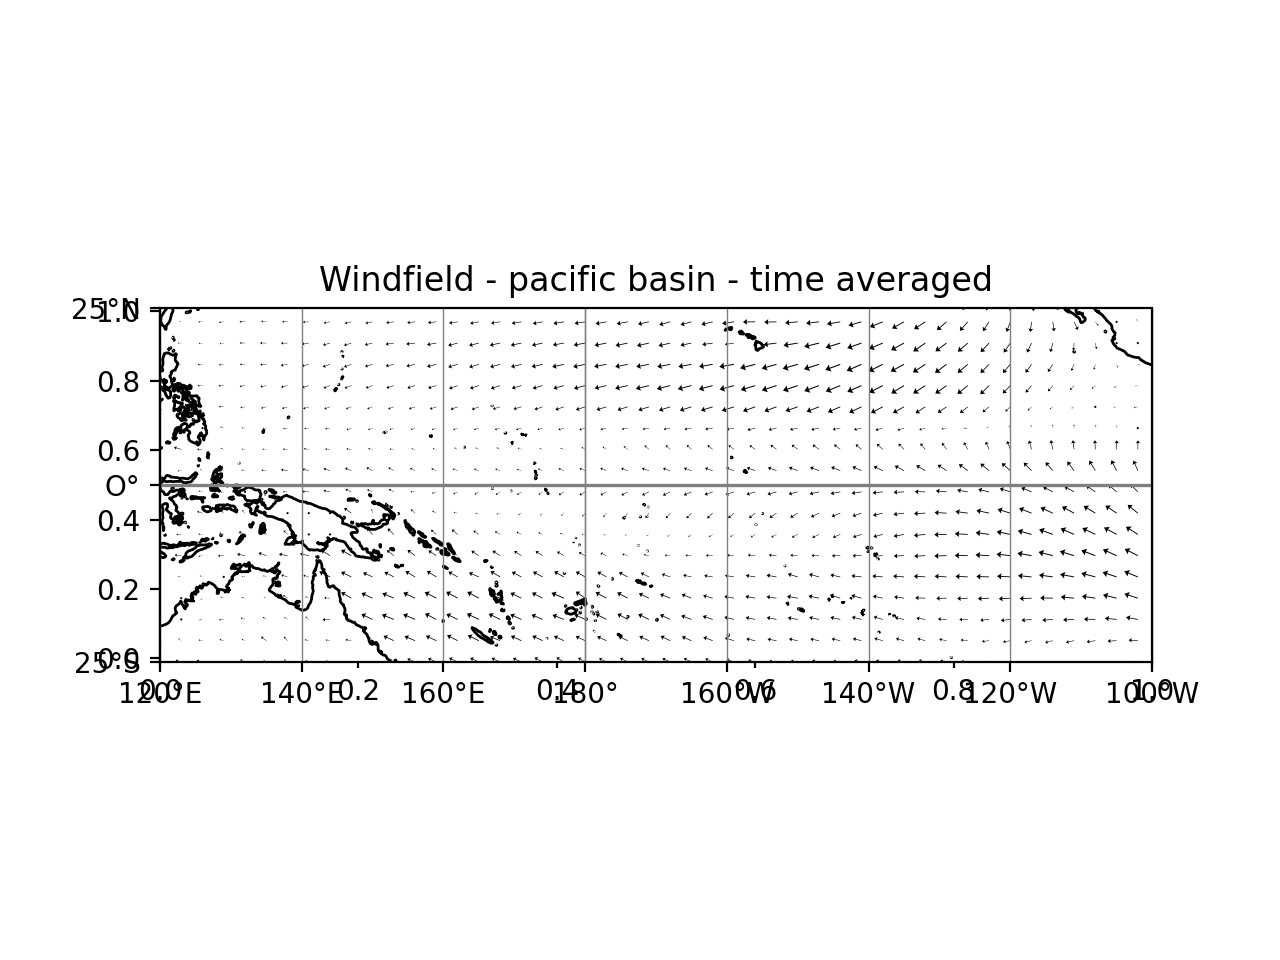

Total time taken, plotting :  0.04358196258544922


In [48]:
# cdo and xarray do not return the data in identical form:
print("data opened with " + method)
if method == "xarray":
    ct_z_ua = z_ua
    ct_z_va = z_va
elif method == "cdo":
    ct_z_ua = dat1.ua[0][0]
    ct_z_va = dat2.va[0][0]
    
print(ct_z_ua.shape)




# Finally plotting
# All plots are thes same, regardless of data opening method used above

begin = zeit()

# plotting every third point otherwise the arrows are too much
ct_z_ua = ct_z_ua[::3,::3]
ct_z_va = ct_z_va[::3,::3]

# making meshgrid fro arrows
X,Y     = np.meshgrid(np.arange(-60,81,3), np.arange(-25,27,3))
print(ct_z_ua.shape, X.shape)
earth_projection = ccrs.PlateCarree(central_longitude=180)

end = zeit()
print("Total time taken, preparing data for plot: ", end - begin)



# plotting
begin = zeit()

#fig, ax = plt.subplots(figsize=(20,10))
fig, ax = plt.subplots(subplot_kw={'aspect': 0.35})

ax = plt.axes(projection=earth_projection)
ax.coastlines(color='black')
ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', xlocs=range(-180,181,20), ylocs=range(-25,26,25))
ax.set_title("Windfield - pacific basin - time averaged", loc='center')
ax.quiver(X,Y, ct_z_ua, ct_z_va, scale = 500, headlength = 5, headwidth = 7, minshaft = 3)
ax.hlines(0,-60,80, linestyles='solid', linewidth=1.2, color = "grey")

ax.set_xlim(-60,80)
ax.set_ylim(-25,25)
ax.set_xticks([-60,-40,-20,0,20,40,60,80])
#ax.set_xticks([])
ax.set_xticklabels([u'120\N{DEGREE SIGN}E', u'140\N{DEGREE SIGN}E', u'160\N{DEGREE SIGN}E', u'180\N{DEGREE SIGN}', u'160\N{DEGREE SIGN}W', u'140\N{DEGREE SIGN}W', u'120\N{DEGREE SIGN}W', u'100\N{DEGREE SIGN}W'])
ax.set_yticks([-25,0,25])
ax.set_yticklabels([u'25\N{DEGREE SIGN}S', u'O\N{DEGREE SIGN}', u'25\N{DEGREE SIGN}N'])

end = zeit()
print("Total time taken, plotting : ", end - begin)